In [1]:
import pandas as pd 
from Response_Spectrum import *
from sympy import symbols, Eq, Function,UnevaluatedExpr, Mul
from sympy import *

#init_printing()
from sympy import Piecewise, nan
import numpy as np

In [2]:
def round_expr(expr, num_digits=2):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(Number)})

def round_equation(eq, num_digits=2):
    lhs = eq.lhs
    rhs = eq.rhs
    rounded_rhs = round_expr(rhs, num_digits)
    return Eq(lhs, rounded_rhs)

In [3]:
x=symbols('x')
expr=1/sin(x) 
f=lambdify(x, expr) 
display(expr)
f(2)


1/sin(x)

1.0997501702946164

In [4]:
RS_params=AASHTO(T=1, PGA=0.4,S_S=0.75,S_1=0.2,SiteClass="B")
# Convert the first element of the array to a numpy number
#RS_params[0].item()
RS_params


(array([0.2]), array(1.), array(1.), array(1.), 0.4, 0.75, 0.2)

In [5]:
# Round the values in each column to n decimal places
def round_values(x,n):
    try:
        return round(x, n)
    except:
        return x
    
# Apply the e-4 formatting to numeric columns
def scientific_format(x):
    try:
        float_value = float(x)
        return '{:.2e}'.format(float_value).replace('+', '')
    except:
        return x

In [2]:
def Iteration(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1,q,k, epsilon):
   
    
    """
    m: Number of supports
    
    n: Number of girders per support
    
    n_c=[0,3,3,0]: Number of columns per support
    ** abutment1, 2 there are no columns
        number of columns = 3 in each pie 1 and 2 
        
    q:    percent of the bridge weight
    
    k:  the increased parameter of  post-yield stiffness      
    
    W_SS: Weight of superstructure including railings, curbs,and barriers to the permanent loads
    
    W_PP: Weight of piers participating with superstructure in dynamic response
    
    W_eff= W_SS + W_PP: Effective weight
    
    W=[W_1,W_2,...,W_m]: Weight of superstructure at each support
    
    K_sub=[K_sub_abut1, K_sub_pie1, K_sub_pie2, K_sub_abut2]: Stiffness of each support in both longitudinal and transverse directions of the bridge
    ** For the abutments, take Ksub,j to be a large number, say 10,000 kips/in.
    
    angle_skew: Angle of skew
    
    PGA,S_1, S_S: Acceleration coefficients for bridge site are given in design statement
    
    SiteClass:  "A", "B", "C","D","E"
    
    epsilon: tolerance
    
    d: set initial guess for the first iteration
 
    """
    
    # Round the values in each column to n decimal places
    def round_values(x,n):
        try:
            return round(x, n)
        except:
            return x

    # Apply the e-4 formatting to numeric columns
    def scientific_format(x):
        try:
            float_value = float(x)
            return '{:.2e}'.format(float_value).replace('+', '')
        except:
            return x


    ##%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # B2.1.1—Step A: Identifty Bridge Data
    ## B2.1.1.2—Step A2: Seismic Hazard
    
    
    # B2.1.2—STEP B: ANALYZE BRIDGE FOR EARTHQUAKE LOADING IN LONGITUDINAL DIRECTION
    ## B2.1.2.1—STEP B1: SIMPLIFIED METHOD
    ### B2.1.2.1.1—Step B1.1: Initial System Displacement and Properties
        
    ##%% Assume that the initial value of displacement d approximates 2.0
    #d=2.0
    i=1
    
    d=10*S_D1
    
    data={}
  
    while True:
        
        #print(f'iteration:{i} ')
        #print(f'd={d}')
        
        ##%% Calculate characteristic strength, Q_d
        Q_d=q*W_SS

        ##%% Calculate Post-yield stiffness, K_d
        K_d=k*(W_SS/d)

        ### B2.1.2.1.2—Step B1.2: Initial Isolator Properties at Supports

        ##%% Calculate the characteristic strength, Q_dj

        Q_dj=[Q_d*(W[j]/W_SS) for j in range(m)]

        ##%% Calculate postelastic stiffness, K_dj

        K_dj= [K_d*(W[j]/W_SS) for j in range(m)]
      

        ### B2.1.2.1.3—Step B1.3: Effective Stiffness of Combined Pier and Isolator System

        ##%% Calculate alpha_j

        alpha_j = [(K_dj[j]*d+Q_dj[j])/(K_sub[j]*d-Q_dj[j]) for j in range(m)]

        ##%% Calculate the effective stiffness, K_effj

        K_effj=[(alpha_j[j]*K_sub[j])/(1+alpha_j[j]) for j in range(m)]

        ### B2.1.2.1.4—Step B1.4: Total Effective Stiffness

        ##%% Calculate the total effective stiffness, Keff, of the bridge:

        K_eff= sum(K_effj)
        #print(f'K_eff: {K_eff}')

        ### B2.1.2.1.5—Step B1.5: Isolation System Displacement at Each Suppor

        ##%% Calculate the displacement of the isolation system, d_isolj

        d_isolj=  [d/(1+ alpha_j[j]) for j in range(m)]
        
        #print(f'd_isolj: {d_isolj}')

        ### B2.1.2.1.6—Step B1.6: Isolation System Stiffness at Each Support

        ##%% Calculate the effective stiffness of the isolation system at support “j”, Kisol,j, for all supports

        K_isolj=[Q_dj[j]/d_isolj[j]+ K_dj[j] for j in range(m)]

        ### 2.1.2.1.7—Step B1.7: Substructure Displacement at Each Support, d_subj

        d_subj= [d- d_isolj[j] for j in range(m)]

        ### B2.1.2.1.8—Step B1.8: Lateral Load in Each Substructure Support

        ##%% Calculate the shear at support “j”, Fsub,j, for all supports:

        F_subj= [K_sub[j]* d_subj[j] for j in range(m)]

        ### B2.1.2.1.9—Step B1.9: Column Shear Force at Each Support

        F_coljk = [F_subj[j]/n_c[j] if n_c[j] != 0 else 0 for j in range(m)]

        ### B2.1.2.1.10—Step B1.10: Effective Period and Damping Ratio

        ##%% Calculate the effective period, T_eff 

        W_eff= W_SS + W_PP #  Effective weight, W_eff
        g=386.4 # (in./s^2) or 9.815(m/s^2)

        T_eff=2*np.pi* (W_eff/(g*K_eff))**(1/2)
        #print(f'T_eff: {T_eff}')

        ##%% Calculate the viscous damping ratio, ξ , of the bridge

        d_yj=[0]*m # taking d_yj=0

        numerator=2*sum([Q_dj[j]*(d_isolj[j]-d_yj[j]) for j in range(m)])

        denominator=np.pi*sum([K_effj[j]*(d_isolj[j]+d_subj[j])**2 for j in range(m)])

        xi= numerator/denominator

        ### B2.1.2.1.11—Step B1.11: Damping Factor

        ##%% Calculate the damping factor, B_L

        B_L=Piecewise(((xi/0.05)**0.3,xi<0.3),(1.7, xi>=0.3))

        ##%%  Calculate the displacement, d_new

        d_new=(9.79*S_D1*T_eff)/B_L
        
        #print(f'd_new: {d_new}')
        
        df = pd.DataFrame({"Pier": ["Abut1", "Pier1", "Pier2", "Abut2"],
                           "$$Q_d$$": Q_d,
                           "$$K_d$$": K_d,      
                           "$$Q_{d,j}$$":Q_dj,
                           "$$K_{d,j}$$":K_dj,
                           "$\\alpha_j$": alpha_j, 
                           "$$K_{eff,j}$$": K_effj,
                           "$$d_{isol,j}$$":d_isolj,
                           "$$K_{isol,j}$$": K_isolj,
                           "$$d_{sub,j}$$": d_subj, 
                           "d": d, "d_new": d_new,        
                           "$$F_{sub,j}$$":F_subj ,
                           "$$ F_{col,j,k}$$": F_coljk,
                           "$$T_{eff}$$": T_eff,
                           "$$K_{eff}$$":K_eff,
                           "$$\\xi$$":xi,
                           "$$B_{L}$$": B_L})
        
        data[i]=df

        ##%%%%%%%%%%%%%%%%%%%%%
        ##%% Calculate the diference, abs(d_new-d) 

        difference=abs(d_new-d)
        #delta=difference/d

        ##%% Check the convergence condition:

        #if difference> epsilon:
        if difference> epsilon:
            d=d_new
            i+=1

        else:
            break
    print(f'Numbers of iteratations: {i}')
    
    # The minimum displacement requirement given by:
    
    d_min=(8*S_D1*T_eff)/B_L
    
    print(f'The minimum displacement requirement given by: d_min={d_min: .2f}')
    
       
    for k in data.keys():
        data[k]['Iteration']=k # Add new column to track the iteration
        for col in data[k].columns:
            if col in ["$\\alpha_j$", "$$d_{sub,j}$$"]:
                data[k][col]=data[k][col].apply(scientific_format)
            else:
                data[k][col]=data[k][col]. apply(round_values, n=2)
        data[k].set_index(['Iteration',"d", "d_new","$$Q_d$$","$$K_d$$","$$T_{eff}$$","$$K_{eff}$$","$$\\xi$$", "$$B_{L}$$", 'Pier'], inplace=True)
    
     # Concatenate the DataFrames from each iteration
    
    concat_df=pd.DataFrame()
   
    for k, df in data.items():
        concat_df = pd.concat([concat_df, df], ignore_index=False)
    
    return data, concat_df


## Example 1.0

In [43]:
# Example 1.0:
m=4
n=6
n_c=[0,3,3,0]
q=0.05 # 5%
k=0.05
W_SS=650.52
W_PP=107.16
W=[44.95,280.31,280.31,44.95]
K_sub=[10000,172.0, 172.0,10000]
angle_skew=0
#%%%%%%
PGA=0.40
S_1=0.20
S_S=0.75
SiteClass="B"


In [44]:
### Calculate Response Spectrum Parameters: C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1
C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1=AASHTO(T=1, PGA=PGA,S_S=S_S,S_1=S_1,SiteClass=SiteClass) 

print(f'C_sm={C_sm}')
print(f'F_pga={F_pga}')
print(f'F_a={F_a}')
print(f'F_v={F_v}')
print(f'A_S={A_S}')
print(f'S_DS={S_DS}')
print(f'S_D1={S_D1}')

C_sm=[0.2]
F_pga=1.0
F_a=1.0
F_v=1.0
A_S=0.4
S_DS=0.75
S_D1=0.2


In [45]:
epsilon=0.05

data, df_Example_1_0=Iteration(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1,q,k, epsilon)


Numbers of iteratations: 3
The minimum displacement requirement given by: d_min= 1.37


In [46]:
df_Example_1_0




$$Q_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                 
1         2.0  1.81  32.53   16.26   1.57        31.43       0.31    1.70      Abut1         2.25   
                                                                               Pier1        14.02   
                                                                               Pier2        14.02   
                                                                               Abut2         2.25   
2         1.81 1.72  32.53   17.99   1.49        34.65       0.31    1.70      Abut1         2.25   
                                                                               Pier1        14.02   
                                                                               Pier2        14.02   
                                                                               Abut2         2.25   
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1         2.25   
                                                                               Pier1        14.02   
                                                                               Pier2        14.02   
                                                                               Abut2         2.25   

                                                                                     $$K_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                
1         2.0  1.81  32.53   16.26   1.57        31.43       0.31    1.70      Abut1        1.12   
                                                                               Pier1        7.01   
                                                                               Pier2        7.01   
                                                                               Abut2        1.12   
2         1.81 1.72  32.53   17.99   1.49        34.65       0.31    1.70      Abut1        1.24   
                                                                               Pier1        7.75   
                                                                               Pier2        7.75   
                                                                               Abut2        1.24   
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1        1.31   
                                                                               Pier1        8.14   
                                                                               Pier2        8.14   
                                                                               Abut2        1.31   

                                                                                     $\alpha_j$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier               
1         2.0  1.81  32.53   16.26   1.57        31.43       0.31    1.70      Abut1   2.25e-04   
                                                                               Pier1   8.49e-02   
                                                                               Pier2   8.49e-02   
                                                                               Abut2   2.25e-04   
2         1.81 1.72  32.53   17.99   1.49        34.65       0.31    1.70      Abut1   2.49e-04   
                                                                               Pier1   9.44e-02   
                                                                               Pier2   9.44e-02   
                                                                               Abut2   2.49e-04   
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1   2.61e-04   
                                                                               Pier1   9.94e-02   
                                                                               Pie

In [47]:
df_conv=list(data.values())[-1] # Obtain the df from the last iteration
df_conv

$$Q_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                 
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1         2.25   
                                                                               Pier1        14.02   
                                                                               Pier2        14.02   
                                                                               Abut2         2.25   

                                                                                     $$K_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1        1.31   
                                                                               Pier1        8.14   
                                                                               Pier2        8.14   
                                                                               Abut2        1.31   

                                                                                     $\alpha_j$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier               
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1   2.61e-04   
                                                                               Pier1   9.94e-02   
                                                                               Pier2   9.94e-02   
                                                                               Abut2   2.61e-04   

                                                                                     $$K_{eff,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                  
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1          2.61   
                                                                               Pier1         15.55   
                                                                               Pier2         15.55   
                                                                               Abut2          2.61   

                                                                                     $$d_{isol,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                   
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1           1.72   
                                                                               Pier1           1.57   
                                                                               Pier2           1.57   
                                                                               Abut2           1.72   

                                                                                     $$K_{isol,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                   
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1           2.61   
                                                                               Pier1          17.09   
                                                                               Pier2          17.09   
                                                                               Abut2           2.61   

                                                                                     $$d_{sub,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                  
3         1.72 1.68  32.53   18.89   1.46        36.31       0.31    1.70      Abut1      4.49e-04   
                                                                               Pier1      1.56e-01   
                        

In [48]:
import os 
current_path=os.getcwd()
folder= "Data_Examples"
folder_path=os.path.join(current_path,folder)
file_name= "Example_1.0.xlsx"
file_path = os.path.join(folder_path, file_name)
file_path

'C:\\Users\\cfcpc2\\Documents\\GitHub\\GitHub_CFC\\BASE-ISOLATION\\Data_Examples\\Example_1.0.xlsx'

In [12]:

df_Example_1_0.to_excel(file_path, index=True)

## Example 1.1

In [13]:
# Example 1.1:
m=4
n=6
n_c=[0,3,3,0]
q=0.075
k=0.1
W_SS=650.52
W_PP=107.16
W=[44.95,280.31,280.31,44.95]
K_sub=[10000,172.0, 172.0,10000]
angle_skew=0
#%%%%%%
PGA=0.40
S_1=0.20
S_S=0.75
SiteClass="D"

    

In [14]:
### Calculate Response Spectrum Parameters: C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1
C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1=AASHTO(T=1, PGA=PGA,S_S=S_S,S_1=S_1,SiteClass=SiteClass) 

print(f'C_sm={C_sm}')
print(f'F_pga={F_pga}')
print(f'F_a={F_a}')
print(f'F_v={F_v}')
print(f'A_S={A_S}')
print(f'S_DS={S_DS}')
print(f'S_D1={S_D1}')

C_sm=[0.4]
F_pga=1.1
F_a=1.2
F_v=2.0
A_S=0.44000000000000006
S_DS=0.8999999999999999
S_D1=0.4


In [15]:
epsilon=0.01

df_Example_1_1=Iteration(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1,q,k, epsilon)


Numbers of iteratations: 2
The minimum displacement requirement given by: d_min= 3.25


In [16]:
df_Example_1_1

$$Q_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                 
1         4.0  3.98  48.79   16.26   1.68        27.5        0.27    1.65      Abut1         3.37   
                                                                               Pier1        21.02   
                                                                               Pier2        21.02   
                                                                               Abut2         3.37   
2         3.98 3.97  48.79   16.34   1.67        27.63       0.27    1.65      Abut1         3.37   
                                                                               Pier1        21.02   
                                                                               Pier2        21.02   
                                                                               Abut2         3.37   

                                                                                     $$K_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                
1         4.0  3.98  48.79   16.26   1.68        27.5        0.27    1.65      Abut1        1.12   
                                                                               Pier1        7.01   
                                                                               Pier2        7.01   
                                                                               Abut2        1.12   
2         3.98 3.97  48.79   16.34   1.67        27.63       0.27    1.65      Abut1        1.13   
                                                                               Pier1        7.04   
                                                                               Pier2        7.04   
                                                                               Abut2        1.13   

                                                                                     $\alpha_j$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier               
1         4.0  3.98  48.79   16.26   1.68        27.5        0.27    1.65      Abut1   1.97e-04   
                                                                               Pier1   7.35e-02   
                                                                               Pier2   7.35e-02   
                                                                               Abut2   1.97e-04   
2         3.98 3.97  48.79   16.34   1.67        27.63       0.27    1.65      Abut1   1.98e-04   
                                                                               Pier1   7.39e-02   
                                                                               Pier2   7.39e-02   
                                                                               Abut2   1.98e-04   

                                                                                     $$K_{eff,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                  
1         4.0  3.98  48.79   16.26   1.68        27.5        0.27    1.65      Abut1          1.97   
                                                                               Pier1         11.78   
                                                                               Pier2         11.78   
                                                                               Abut2          1.97   
2         3.98 3.97  48.79   16.34   1.67        27.63       0.27    1.65      Abut1          1.98   
                                                                               Pier1         11.84   
                                                                               Pier2         11.84   
                                                                               Abut2          1.98   

                                                              

In [17]:
current_path=os.getcwd()
folder= "Data_Examples"
folder_path=os.path.join(current_path,folder)
file_name= "Example_1.1.xlsx"
file_path = os.path.join(folder_path, file_name)
file_path

'C:\\Users\\cfcpc2\\Documents\\GitHub\\GitHub_CFC\\BASE-ISOLATION\\Data_Examples\\Example_1.1.xlsx'

In [18]:
df_Example_1_1.to_excel(file_path, index=True)

## Example 1.2

In [19]:
# Example 1.2:
m=4
n=6
n_c=[0,3,3,0]
q=0.075
k=0.1
W_SS=650.52
W_PP=107.16
W=[44.95,280.31,280.31,44.95]
K_sub=[10000,172.0, 172.0,10000]
angle_skew=0
#%%%%%%
PGA=0.40
S_1=0.60
S_S=0.75
SiteClass="B"

### Calculate Response Spectrum Parameters: C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1
C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1=AASHTO(T=1, PGA=PGA,S_S=S_S,S_1=S_1,SiteClass=SiteClass) 

print(f'C_sm={C_sm}')
print(f'F_pga={F_pga}')
print(f'F_a={F_a}')
print(f'F_v={F_v}')
print(f'A_S={A_S}')
print(f'S_DS={S_DS}')
print(f'S_D1={S_D1}')



C_sm=[0.6]
F_pga=1.0
F_a=1.0
F_v=1.0
A_S=0.4
S_DS=0.75
S_D1=0.6


In [20]:
epsilon=0.05

df_Example_1_2=Iteration(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1,q,k, epsilon)

df_Example_1_2

Numbers of iteratations: 6
The minimum displacement requirement given by: d_min= 7.06


$$Q_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                 
1         6.0  7.25  48.79   10.84   2.04        18.54       0.27    1.65      Abut1         3.37   
                                                                               Pier1        21.02   
                                                                               Pier2        21.02   
                                                                               Abut2         3.37   
2         7.25 7.95  48.79   8.97    2.24        15.40       0.27    1.66      Abut1         3.37   
                                                                               Pier1        21.02   
                                                                               Pier2        21.02   
                                                                               Abut2         3.37   
3         7.95 8.31  48.79   8.18    2.35        14.07       0.27    1.66      Abut1         3.37   
                                                                               Pier1        21.02   
                                                                               Pier2        21.02   
                                                                               Abut2         3.37   
4         8.31 8.50  48.79   7.82    2.40        13.46       0.27    1.66      Abut1         3.37   
                                                                               Pier1        21.02   
                                                                               Pier2        21.02   
                                                                               Abut2         3.37   
5         8.50 8.59  48.79   7.65    2.42        13.18       0.27    1.66      Abut1         3.37   
                                                                               Pier1        21.02   
                                                                               Pier2        21.02   
                                                                               Abut2         3.37   
6         8.59 8.63  48.79   7.57    2.44        13.04       0.27    1.66      Abut1         3.37   
                                                                               Pier1        21.02   
                                                                               Pier2        21.02   
                                                                               Abut2         3.37   

                                                                                     $$K_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                
1         6.0  7.25  48.79   10.84   2.04        18.54       0.27    1.65      Abut1        0.75   
                                                                               Pier1        4.67   
                                                                               Pier2        4.67   
                                                                               Abut2        0.75   
2         7.25 7.95  48.79   8.97    2.24        15.40       0.27    1.66      Abut1        0.62   
                                                                               Pier1        3.86   
                                                                               Pier2        3.86   
                                                                               Abut2        0.62   
3         7.95 8.31  48.79   8.18    2.35        14.07       0.27    1.66      Abut1        0.57   
                                                                               Pier1        3.53   
                                                                               Pier2        3.53   
                                                                               Abut2        0.57   
4         8.31 8.50  48.79   7.82    2.40        13.46     

In [21]:
0.075*650.52


48.788999999999994

## Example 2.0

In [22]:
# Example 2.0:
m=4
n=3
n_c=[0,1,1,0]
q=0.05
k=0.05
W_SS=1651.32
W_PP=256.26
W=[168.48,657.18,657.18,168.18]
K_sub=[10000,288.87, 288.87,10000]
angle_skew=0
#%%%%%%
PGA=0.40
S_1=0.20
S_S=0.75
SiteClass="B"

### Calculate Response Spectrum Parameters: C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1
C_sm, F_pga, F_a, F_v, A_S, S_DS,S_D1=AASHTO(T=1, PGA=PGA,S_S=S_S,S_1=S_1,SiteClass=SiteClass) 

print(f'C_sm={C_sm}')
print(f'F_pga={F_pga}')
print(f'F_a={F_a}')
print(f'F_v={F_v}')
print(f'A_S={A_S}')
print(f'S_DS={S_DS}')
print(f'S_D1={S_D1}')



C_sm=[0.2]
F_pga=1.0
F_a=1.0
F_v=1.0
A_S=0.4
S_DS=0.75
S_D1=0.2


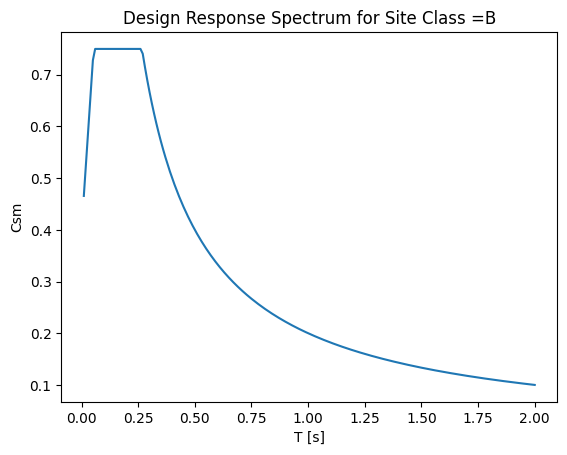

In [23]:
T_max=2
Plot(T_max,PGA, S_S, S_1, SiteClass)

In [24]:
epsilon=0.002

df_Example_1_3=Iteration(m,n,n_c,W_SS, W_PP,W,K_sub,angle_skew,S_D1,q,k, epsilon)

df_Example_1_3

Numbers of iteratations: 7
The minimum displacement requirement given by: d_min= 1.35


$$Q_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                 
1         2.0  1.81  82.57   41.28   1.57        79.01       0.3     1.70      Abut1         8.42   
                                                                               Pier1        32.86   
                                                                               Pier2        32.86   
                                                                               Abut2         8.41   
2         1.81 1.72  82.57   45.64   1.50        86.96       0.30    1.70      Abut1         8.42   
                                                                               Pier1        32.86   
                                                                               Pier2        32.86   
                                                                               Abut2         8.41   
3         1.72 1.69  82.57   47.88   1.46        91.03       0.30    1.70      Abut1         8.42   
                                                                               Pier1        32.86   
                                                                               Pier2        32.86   
                                                                               Abut2         8.41   
4         1.69 1.67  82.57   48.99   1.45        93.02       0.30    1.70      Abut1         8.42   
                                                                               Pier1        32.86   
                                                                               Pier2        32.86   
                                                                               Abut2         8.41   
5         1.67 1.66  82.57   49.53   1.44        93.99       0.30    1.70      Abut1         8.42   
                                                                               Pier1        32.86   
                                                                               Pier2        32.86   
                                                                               Abut2         8.41   
6         1.66 1.65  82.57   49.78   1.44        94.45       0.30    1.70      Abut1         8.42   
                                                                               Pier1        32.86   
                                                                               Pier2        32.86   
                                                                               Abut2         8.41   
7         1.65 1.65  82.57   49.90   1.43        94.67       0.30    1.70      Abut1         8.42   
                                                                               Pier1        32.86   
                                                                               Pier2        32.86   
                                                                               Abut2         8.41   

                                                                                           $$K_{d,j}$$  \
Iteration d    d_new $$Q_d$$ $$K_d$$ $$T_{eff}$$ $$K_{eff}$$ $$\xi$$ $$B_{L}$$ Pier                      
1         2.0  1.81  82.57   41.28   1.57        79.01       0.3     1.70      Abut1              4.21   
                                                                               Pier1             16.43   
                                                                               Pier2             16.43   
                                                                               Abut2               4.2   
2         1.81 1.72  82.57   45.64   1.50        86.96       0.30    1.70      Abut1              4.66   
                                                                               Pier1             18.16   
                                                                               Pier2             18.16   
                                                                               Abut2              4.6

In [25]:
current_path=os.getcwd()
folder= "Data_Examples"
folder_path=os.path.join(current_path,folder)
file_name= "Example_2.0.xlsx"
file_path = os.path.join(folder_path, file_name)
file_path

'C:\\Users\\cfcpc2\\Documents\\GitHub\\GitHub_CFC\\BASE-ISOLATION\\Data_Examples\\Example_2.0.xlsx'

In [14]:

from sympy import symbols
def Iteration_conv(m, n, n_c, W_SS, W_PP, W, K_sub, angle_skew, S_D1, q, k, epsilon):
    # Define symbolic variables
    m_sym, n_sym, n_c_sym, W_SS_sym, W_PP_sym, W_sym, K_sub_sym, angle_skew_sym, S_D1_sym, q_sym, k_sym, epsilon_sym, d_sym = symbols('m n n_c W_SS W_PP W K_sub angle_skew S_D1 q k epsilon d')

    # Define your calculations using the symbolic variables
    d_sym = 10 * S_D1_sym
    Q_d_sym = q_sym * W_SS_sym
    K_d_sym = k_sym * (W_SS_sym / d_sym)
    Q_dj_sym = [Q_d_sym * (W_sym[j] / W_SS_sym) for j in range(m)]
    K_dj_sym = [K_d_sym * (W_sym[j] / W_SS_sym) for j in range(m)]

    # Continue with your calculations and expressions using the symbolic variables

    # Return your symbolic expressions or results as needed
    return d_sym, Q_d_sym, K_d_sym, Q_dj_sym, K_dj_sym




In [15]:

# Define symbolic variables
m_sym, n_sym, n_c_sym, W_SS_sym, W_PP_sym, W_sym, K_sub_sym, angle_skew_sym, S_D1_sym, q_sym, k_sym, epsilon_sym = symbols(
    'm n n_c W_SS W_PP W K_sub angle_skew S_D1 q k epsilon')

# Call the symbolic function
result = Iteration_conv(m_sym, n_sym, n_c_sym, W_SS_sym, W_PP_sym, W_sym, K_sub_sym, angle_skew_sym, S_D1_sym, q_sym, k_sym, epsilon_sym)

# Unpack the results
d_symbolic, Q_d_symbolic, K_d_symbolic, Q_dj_symbolic, K_dj_symbolic = result

TypeError: 'Symbol' object cannot be interpreted as an integer